In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

from automations import RM1

# 🐀 collect metadata for the rat

In [24]:
SAVE_DIRECTORY_DW327 = Path(fr'D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327')
DATA_DIRECTORY = Path(fr'D:\SynologyDrive\CMU.80 Data\82 External Data\82.002 Sample Rat Data from RM1 Project')
PROBE_DIRECTORY = Path(r'D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.001 A1x32-Edge-5mm-20-177-A32\A1x32-Edge-5mm-20-177-A32.prb')
DW327 = RM1.Rat(DATA_DIRECTORY, PROBE_DIRECTORY, "DW327")

Reading DRGS_10_241125_150417...
Error reading stream 2 for DRGS_10_241125_150417. continuing...
Reading DRGS_11_241125_151101...
Error reading stream 2 for DRGS_11_241125_151101. continuing...
Reading DRGS_12_241125_151746...
Error reading stream 2 for DRGS_12_241125_151746. continuing...
Reading DRGS_1_241125_134024...
Error reading stream 2 for DRGS_1_241125_134024. continuing...
Reading DRGS_2_241125_140406...
Error reading stream 2 for DRGS_2_241125_140406. continuing...
Reading DRGS_3_241125_141057...
Error reading stream 2 for DRGS_3_241125_141057. continuing...
Reading DRGS_4_241125_141635...
Error reading stream 2 for DRGS_4_241125_141635. continuing...
Reading DRGS_5_241125_142348...
Error reading stream 2 for DRGS_5_241125_142348. continuing...
Reading DRGS_6_241125_143021...
Error reading stream 2 for DRGS_6_241125_143021. continuing...
Reading DRGS_7_241125_143654...
Error reading stream 2 for DRGS_7_241125_143654. continuing...
Reading DRGS_8_241125_144608...
Error readin

In [25]:
DW327.qst_trial_notes

5,Trial Number,Condition,amp,PW (us),Freq. (Hz),drgDur. (s),Stimuli,temp,Stimuli Dur.
Trial Number,,,,,,,,,
1,1,vf,63,300,5,180,vf,NaN,pp dur 30
2,2,NaN,63,300,100,180,vf,NaN,paw
3,3,NaN,63,300,100,180,vf,NaN,paw
4,4,NaN,63,300,5,180,vf,NaN,paw
5,5,NaN,63,300,20,180,vf,NaN,paw
6,6,NaN,63,300,20,180,vf,NaN,paw
7,7,NaN,63,300,5,180,vf,NaN,toe
8,8,NaN,63,300,100,180,vf,NaN,toe
9,9,NaN,63,300,100,180,vf,NaN,paw


# testing a new way of filtering units

### define new threshold: the unit must have a non-zero firing rate for more than this percent of time windows:

In [26]:
# Define the threshold for zero proportion
zero_threshold = 0.30  # Example: remove columns where more than this % of values are zero

### rerun the analysis with this filtering technique

In [27]:

# Define the folder path
folder_path = r"D:\SynologyDrive\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\tables"

# Dictionary to store the merged data
voltage_data = {}
cluster_firing_data = {}
groups = {}
cluster_firing_data_filtered = {}
cluster_unresponsiveness_percentage = {} # create a dataframe for the number of rows with 0 in the firing rate
neuron_firing_div_von_frey = {}




# Iterate through all files in the folder
for file in os.listdir(folder_path):
    if file.endswith("_average_vf_voltage_windowed.xlsx"):
        # Extract trial name (assuming consistent naming convention)
        trial_name = file.split("_average_vf_voltage_windowed.xlsx")[0]

        # Construct file paths
        voltage_file = os.path.join(folder_path, f"{trial_name}_average_vf_voltage_windowed.xlsx")
        firing_file = os.path.join(folder_path, f"{trial_name}_cluster_firing_rates_windowed.xlsx")

        # Ensure both files exist before processing
        if os.path.exists(voltage_file) and os.path.exists(firing_file):
            voltage_windows = pd.read_excel(voltage_file)
            cluster_firing = pd.read_excel(firing_file).iloc[:-2, :]
            group = cluster_firing["group"]

            # Calculate the proportion of zero values in each column (excluding specific columns)
            zero_proportions = ((cluster_firing == 0).sum() / len(cluster_firing)).drop(["group", "avg_voltage"], errors='ignore')
            # zero_proportions = zero_proportions.drop(["group", "avg_voltage"], errors='ignore')

            # Filter columns based on the threshold
            columns_to_keep = zero_proportions[zero_proportions <= zero_threshold].index
            df_filtered = cluster_firing[columns_to_keep].drop(columns = ["Unnamed: 0"])

            # divide the firing rate of the filtered cluster by the average voltage
            cluster_firing_div_voltage_windows = df_filtered.div(voltage_windows["avg_voltage"].values, axis=0)
            cluster_firing_div_voltage_windows_with_groups = cluster_firing_div_voltage_windows.copy()
            cluster_firing_div_voltage_windows_with_groups["group"] = group

            # Calculate the mean for each cluster grouped by "pre-stim" and "post-stim"
            # pre_post_stim_comparison = cluster_firing_div_voltage_windows_with_groups.groupby("group").mean()

            ## store the results of each metric in a dictionary:
            # store the firing rate of clusters, voltage, and group of each time window
            voltage_data[trial_name] = voltage_windows
            cluster_firing_data[trial_name] = cluster_firing.drop(columns = ["Unnamed: 0"])
            groups[trial_name] = group
            # Store the filtered data and zero proportions
            cluster_firing_data_filtered[trial_name] = df_filtered
            # store the percentage of stimulus windows 
            cluster_unresponsiveness_percentage[trial_name] = zero_proportions
            # store the cluster firing divided by von frey

            ## finally, calculate the average firing rate, divided by average von frey voltage, pre & post stim
            neuron_firing_div_von_frey[trial_name] = cluster_firing_div_voltage_windows_with_groups.groupby("group").mean()


In [28]:
neuron_firing_div_von_frey["VF_1_241125_153746"]

,0,1,2,3,4,7,8,9,10,17
group,,,,,,,,,,
post-stim,0.000042,0.000059,0.000027,0.000267,0.000021,0.000048,0.000106,0.000085,0.000022,0.000064
pre-stim,0.000020,0.000058,0.000039,0.000517,0.000027,0.000012,0.000077,0.000030,0.000054,0.000023


In [29]:
neuron_firing_div_von_frey["VF_1_241125_153746"]

,0,1,2,3,4,7,8,9,10,17
group,,,,,,,,,,
post-stim,0.000042,0.000059,0.000027,0.000267,0.000021,0.000048,0.000106,0.000085,0.000022,0.000064
pre-stim,0.000020,0.000058,0.000039,0.000517,0.000027,0.000012,0.000077,0.000030,0.000054,0.000023


# 📊 plot with newly filtered results

## plot methods

In [30]:

def plot_pre_post_stim_from_firing_div_von_frey(neuron_firing_div_von_frey,
                                                rat_qst_notes=None):
    """
    Plots pre- vs. post-stim data (firing_rate / voltage) for each trial.
    Each trial's clusters are displayed as points in a scatter plot, 
    with x = pre-stim ratio, y = post-stim ratio.
    
    If a 'rat_qst_notes' DataFrame is provided, looks up each trial's 
    frequency (Hz) to color-code points. Otherwise, all points appear in one color.

    Parameters
    ----------
    neuron_firing_div_von_frey : dict
        Maps trial_name -> DataFrame, where each DataFrame has:
            - Index = [pre-stim, post-stim]
            - Columns = cluster IDs
            - Values = ratio (firing / voltage)
    rat_qst_notes : pd.DataFrame, optional
        A DataFrame (e.g., DW327.qst_trial_notes) with a numeric index for each 
        trial number and at least one column named 'Freq. (Hz)' 
        to retrieve the frequency for color-coding.

    Returns
    -------
    None
    """

    all_points = []  # Will hold tuples of (pre_stim_value, post_stim_value, freq_hz)

    # Go through each trial in the dictionary
    for trial_name, ratio_df in neuron_firing_div_von_frey.items():
        
        # Attempt to parse out the trial number from `trial_name` 
        # (adapt this logic to match how your trial names are structured)
        trial_parts = trial_name.split('_')
        freq_hz = None
        if rat_qst_notes is not None and len(trial_parts) > 1:
            try:
                trial_num = int(trial_parts[1])
                # If 'Freq. (Hz)' is in rat_qst_notes, we fetch frequency
                if trial_num in rat_qst_notes.index and 'Freq. (Hz)' in rat_qst_notes.columns:
                    freq_hz = rat_qst_notes.loc[trial_num, 'Freq. (Hz)']
            except ValueError:
                pass  # If we can't parse it, freq_hz remains None

        # Check that ratio_df has the expected rows
        if not {'pre-stim', 'post-stim'}.issubset(ratio_df.index):
            print(f"Trial '{trial_name}' missing 'pre-stim' or 'post-stim' rows. Skipping.")
            continue

        # For each cluster (column) in the DataFrame, extract the pre/post values
        for cluster_col in ratio_df.columns:
            pre_val = ratio_df.loc['pre-stim', cluster_col]
            post_val = ratio_df.loc['post-stim', cluster_col]

            # Skip if either value is NaN
            if pd.isna(pre_val) or pd.isna(post_val):
                continue

            # Store the point with freq_hz (None if not found)
            all_points.append((pre_val, post_val, freq_hz))

    # If we have no points to plot, just return
    if not all_points:
        print("No data points to plot.")
        return

    # Create a DataFrame for plotting
    all_points_df = pd.DataFrame(all_points, columns=['pre_stim', 'post_stim', 'freq_hz'])

    # If we have frequencies, color by freq_hz; otherwise single color
    # Convert freq_hz to numeric to handle anything that can be cast (or stays None if missing)
    all_points_df['freq_hz'] = pd.to_numeric(all_points_df['freq_hz'], errors='coerce')
    unique_freqs = all_points_df['freq_hz'].dropna().unique()

    # Plot
    plt.figure(figsize=(8, 6))
    if len(unique_freqs) == 0:
        # No valid frequency info -> single color scatter
        plt.scatter(all_points_df['pre_stim'], all_points_df['post_stim'], alpha=0.7)
        plt.title("Pre vs. Post Stim Ratio (All Trials)")
    else:
        # We have at least one valid frequency -> color-code by freq
        cmap = plt.get_cmap('tab10')
        freq_to_color = {freq: cmap(i % 10) for i, freq in enumerate(np.sort(unique_freqs))}

        for freq in freq_to_color:
            freq_data = all_points_df[all_points_df['freq_hz'] == freq]
            plt.scatter(freq_data['pre_stim'], freq_data['post_stim'],
                        color=freq_to_color[freq], alpha=0.7, label=f'{freq} Hz')

        plt.legend(title='Stim Frequency')
        plt.title("Pre vs. Post Stim Ratio (All Trials, Colored by Freq)")

    # Optional diagonal line: y = x
    combined_vals = pd.concat([all_points_df['pre_stim'], all_points_df['post_stim']])
    min_val, max_val = combined_vals.min(), combined_vals.max()
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='y = x')

    plt.xlabel('Pre-Stim Ratio (firing / voltage)')
    plt.ylabel('Post-Stim Ratio (firing / voltage)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_pre_post_stim_from_firing_div_von_frey_with_trend(
    neuron_firing_div_von_frey,
    rat_qst_notes=None
):
    """
    Plots pre- vs. post-stim data (firing_rate / voltage) for each trial.
    Each trial's clusters are displayed as points in a scatter plot, 
    with x = pre-stim ratio, y = post-stim ratio.
    
    If a 'rat_qst_notes' DataFrame is provided, looks up each trial's 
    frequency (Hz) to color-code points. Otherwise, all points appear 
    in one color. For each frequency group, a linear trend line is 
    added (intercept fixed at 0).

    Parameters
    ----------
    neuron_firing_div_von_frey : dict
        Maps trial_name -> DataFrame, where each DataFrame has:
            - Index = [pre-stim, post-stim]
            - Columns = cluster IDs
            - Values = ratio (firing / voltage)
    rat_qst_notes : pd.DataFrame, optional
        A DataFrame with a numeric index for each trial number and 
        at least one column named 'Freq. (Hz)' for color-coding.

    Returns
    -------
    None
    """

    all_points = []  # Will hold tuples of (pre_stim_value, post_stim_value, freq_hz)

    for trial_name, ratio_df in neuron_firing_div_von_frey.items():
        # Attempt to parse out the trial number from `trial_name` 
        trial_parts = trial_name.split('_')
        freq_hz = None

        if rat_qst_notes is not None and len(trial_parts) > 1:
            try:
                trial_num = int(trial_parts[1])
                if trial_num in rat_qst_notes.index and 'Freq. (Hz)' in rat_qst_notes.columns:
                    freq_hz = rat_qst_notes.loc[trial_num, 'Freq. (Hz)']
            except ValueError:
                pass  # If we can't parse it, freq_hz remains None

        # Check that ratio_df has pre-stim and post-stim rows
        if not {'pre-stim', 'post-stim'}.issubset(ratio_df.index):
            continue

        # For each cluster in the DataFrame, extract pre and post values
        for cluster_col in ratio_df.columns:
            pre_val = ratio_df.loc['pre-stim', cluster_col]
            post_val = ratio_df.loc['post-stim', cluster_col]

            if pd.isna(pre_val) or pd.isna(post_val):
                continue

            all_points.append((pre_val, post_val, freq_hz))

    if not all_points:
        return

    # Create a DataFrame for plotting
    all_points_df = pd.DataFrame(all_points, columns=['pre_stim', 'post_stim', 'freq_hz'])

    # Convert freq_hz to numeric if present
    all_points_df['freq_hz'] = pd.to_numeric(all_points_df['freq_hz'], errors='coerce')
    unique_freqs = all_points_df['freq_hz'].dropna().unique()

    plt.figure(figsize=(8, 6))

    # If no frequency info is available, do a single scatter and skip color grouping
    if len(unique_freqs) == 0:
        plt.scatter(all_points_df['pre_stim'], all_points_df['post_stim'], alpha=0.7)
    else:
        cmap = plt.get_cmap('tab10')
        freq_to_color = {freq: cmap(i % 10) for i, freq in enumerate(np.sort(unique_freqs))}

        for freq in freq_to_color:
            freq_data = all_points_df[all_points_df['freq_hz'] == freq]
            color = freq_to_color[freq]

            # Scatter plot for this group
            plt.scatter(freq_data['pre_stim'], freq_data['post_stim'], color=color,
                        alpha=0.7, label=f'{freq} Hz')

            # Linear trend with intercept = 0
            if len(freq_data) > 1:
                x = freq_data['pre_stim'].values
                y = freq_data['post_stim'].values
                slope = np.sum(x * y) / np.sum(x**2)
                xvals = np.linspace(x.min(), x.max(), 100)
                plt.plot(xvals, slope * xvals, color=color, linewidth=2, alpha=0.7)

        plt.legend(title='Stim Frequency')

    # Optional diagonal line y = x
    combined_vals = pd.concat([all_points_df['pre_stim'], all_points_df['post_stim']])
    min_val, max_val = combined_vals.min(), combined_vals.max()
    plt.plot([min_val, max_val], [min_val, max_val], 'k--')

    plt.xlabel('Pre-Stim Ratio (firing / voltage)')
    plt.ylabel('Post-Stim Ratio (firing / voltage)')
    plt.title("Pre vs. Post Stim Ratio (All Trials)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


## plots

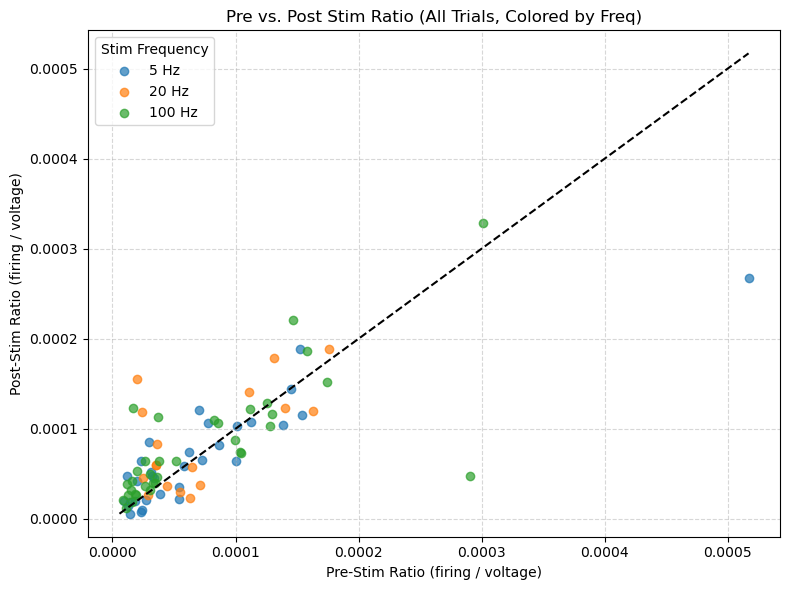

In [32]:
plot_pre_post_stim_from_firing_div_von_frey(neuron_firing_div_von_frey,
                                                rat_qst_notes=DW327.qst_trial_notes)

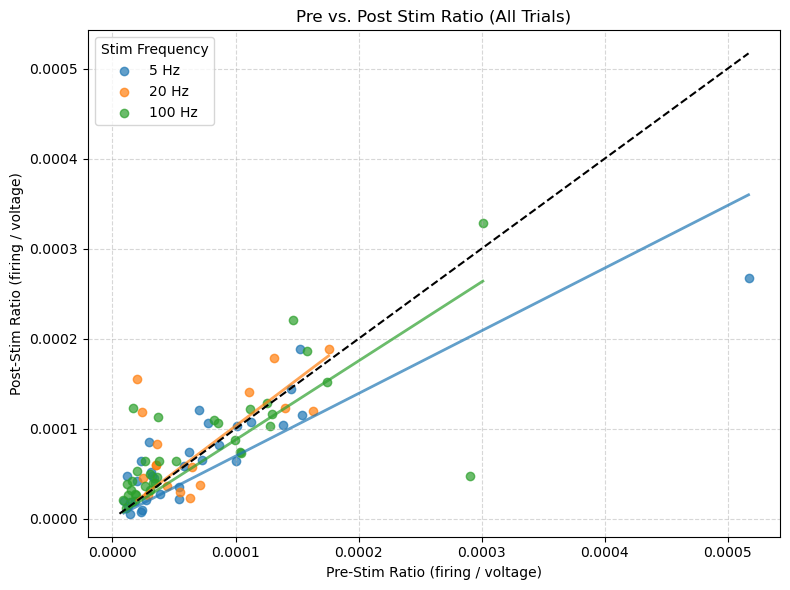

In [33]:
plot_pre_post_stim_from_firing_div_von_frey_with_trend(neuron_firing_div_von_frey,
                                                rat_qst_notes=DW327.qst_trial_notes)